In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# GET FEATURE FILES FROM GDRIVE 
# COLAB ONLY - MOVE FEATURE FILES TO WORKING DIRECTORY
# 
import os
import gc
import shutil

if os.getenv("COLAB_RELEASE_TAG") and not os.path.exists(WORKING_DIR):
  !mkdir '/content/asl-work'

if os.getenv("COLAB_RELEASE_TAG"):
   # shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/feature_data{FRAMES_OUT}.npy", f"{WORKING_DIR}")
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/feature_labels.npy", f"{WORKING_DIR}")
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/sign_to_prediction_index_map.json", f"{WORKING_DIR}")



In [13]:
# Jupiter  MacOS
BASE_DIR = "/Users/johnhanratty/ASLtest/asl-signs"  #"/Users/johnhanratty/ASLtest/asl-signs"
WORKING_DIR = "/Users/johnhanratty/ASLtest"
ARCHIVE_DIR = "/Users/johnhanratty/ASLtest"
MODEL_DIR = "/Users/johnhanratty/ASLtest/models"

# !pip install nb_black --quiet
# %load_ext lab_black

# Colab
# BASE_DIR = "/content/asl-signs"   #"/content/drive/MyDrive/GaggleSignLang/asl-signs"
# WORKING_DIR = "/content/asl-work"
# ARCHIVE_DIR = "/content/drive/MyDrive/GaggleSignLang"
# !pip install nb_black --quiet
# print('-----ok')
# %load_ext nb_black

# KAGGLE
# BASE_DIR = "/kaggle/input/asl-signs"
# WORKING_DIR = "/kaggle/working"
# ARCHIVE_DIR = "/kaggle/working"
# MODEL_DIR  = "/kaggle/working"
# !pip install nb_black --quiet --root-user-action=ignore
# %load_ext lab_black

import os
import gc
import shutil
import time

import json
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle
from random import seed, sample

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings(action='ignore')

LANDMARK_FILES_DIR = f'{BASE_DIR}/train_landmark_files'
TRAIN_FILE = f"{BASE_DIR}/train.csv"

FRAMES_OUT = 32 # 16
PTS_IN_FRAME = 345
DIMC = [0,1,2]
DIMS = len(DIMC)
WORKERS = 0   # dataoader work var  0 for MAC, 4 for online


print('done')

done


In [14]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [37]:
#FEATUREGEN MODEL
ROWS_PER_FRAME = 543  # combined face, lefth, pose, righth

# FILTER FEATURES IN EACH FRAME  - FACE, POSE & HANDs
class FeatureGen(nn.Module):
    def __init__(self):
        super(FeatureGen, self).__init__()
        
        print(MODEL_DIR)
        with open(f"{MODEL_DIR}/modelPCA_60.pkl", 'rb') as handle:
            self.pca_X = pickle.load(handle)

        pass
    
    def forward(self, x):
        # FILTER TO SPECIFIED FRAMES (FRAMES_OUT)
        seed(24)
        x = np.array(x)
        n_frames = x.shape[0]
        # Trim to # of frames to FRAMES_OUT
        if n_frames > FRAMES_OUT:
            idx = sorted((sample(range(0, n_frames), FRAMES_OUT)))
            x=x[idx,:,:]
        n_frames = x.shape[0]
        # FLATTENING ROWS BY TYPE and CONCATENATING TO ONE ROW PER FRAME 3D (XYZ)
        # INPUT NUMPY, TORCH OUTPUT

        # Grab data type (e.g. one point on hand) by selecting rows for each frame
        # face_x = x[:,:468,:].contiguous().view(-1, 468*3)
        lips_idx = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324, 146, 91, 181, 84, 17, 314, 405, 321, 375]
        lips_x = x[:, lips_idx,:].reshape(-1, len(lips_idx)*3)
        lefth_x = x[:,468:489,:].reshape(-1, 21*3)
        pose_x = x[:,489:522,:].reshape(-1, 33*3)
        righth_x = x[:,522:,:].reshape(-1, 21*3)

        if np.isnan(lefth_x).sum() < np.isnan(righth_x).sum():
            prime_x = lefth_x
            second_x = righth_x
        else:
            prime_x = righth_x.reshape(righth_x.shape[0], -1, DIMS)
            prime_x[:,:,0] = np.add(np.nanmax(prime_x[:,:,0], axis=1).reshape(-1,1),
                                    prime_x[:, :, 0])
            prime_x = prime_x.reshape(prime_x.shape[0],-1)
            
            second_x = lefth_x.reshape(lefth_x.shape[0], -1, DIMS)
            second_x[:,:,0] = np.subtract(np.nanmax(second_x[:,:,0], axis=1).reshape(-1,1),
                                          second_x[:, :, 0])
            second_x = second_x.reshape(second_x.shape[0],-1)
            
        # ?? remove empty frames ???
        
        # flatten types into one row per frame
        xfeat = np.full([FRAMES_OUT, PTS_IN_FRAME], np.nan)
        offset = (FRAMES_OUT - n_frames) // 2  # center frames in output data in each frame in video
        xfeat[offset:n_frames+offset,:] = np.concatenate([lips_x, prime_x, pose_x, second_x], axis=1)  # concatenate types
        
        xfeat = np.nan_to_num(xfeat, copy=False) 
        pca_out = self.pca_X.transform(xfeat.reshape(xfeat.shape[0],-1))
        return pca_out


In [38]:

## PROCESS EACH ROW (ONE PARQUET PER ROW)
def convert_row(row):
    x = load_relevant_data_subset(os.path.join(BASE_DIR, row[1].path))
    x = feature_converter(torch.tensor(x))
    return x, row[1].label

## LOOP THROUGH PARQUET FILES LISTED IN TRAIN FILE
##  SAVE RESULTS 
def convert_and_save_data():
    label_map = json.load(open(f"{BASE_DIR}/sign_to_prediction_index_map.json", "r"))
    df = pd.read_csv(TRAIN_FILE)
    df['label'] = df['sign'].map(label_map)
    
    print("Convert&Save", df.shape)
    #### FOR TESTING #################
    #df = df[0:20]
    ##################################

    npdata = np.zeros((df.shape[0], FRAMES_OUT, 60))
    nplabels = np.zeros(df.shape[0])
    
    results = map(convert_row, df.iterrows())
    for i, (x,y) in tqdm(enumerate(results), total=df.shape[0]):
            npdata[i,:] = x
            nplabels[i] = y
    return npdata, nplabels
 

feature_converter = FeatureGen()
datax, datay = convert_and_save_data()



/Users/johnhanratty/ASLtest/models
Convert&Save (94477, 5)


100%|████████████████████████████████████| 94477/94477 [09:15<00:00, 170.09it/s]


In [ ]:
# Save dataset
np.save(f"{WORKING_DIR}/tsai_data{FRAMES_OUT}.npy", datax)
np.save(f"{WORKING_DIR}/tsai_labels.npy", datay)
 

In [ ]:
# Load dataset
datax = np.load(f"{WORKING_DIR}/tsai_data{FRAMES_OUT}.npy")
datay = np.load(f"{WORKING_DIR}/tsai_labels.npy") 

# datax = np.load(f"/kaggle/input/tsai-data/tsai_data32.npy")
# datay = np.load(f"/kaggle/input/tsai-data/tsai_labels.npy") 



# PCA Encoding

In [48]:
# from sklearn.decomposition import PCA
# COMPONENTS = 60
# print(datax.shape)

# datax = np.nan_to_num(datax, copy=False)
# shp = datax.shape
# pca_X = PCA(n_components=COMPONENTS, random_state=999) 
# pca_X.fit(datax.reshape(shp[0]*shp[1], -1))
# print(np.cumsum(pca_X.explained_variance_ratio_ *100))

# with open(f"{MODEL_DIR}/modelPCA_60.pkl", 'wb') as handle:
#     pickle.dump(pca_X, handle)


(94477, 32, 60)


KeyboardInterrupt: 

In [9]:
print(np.cumsum(pca_X.explained_variance_ratio_ *100))

[75.37889603 83.21322418 90.03248594 93.09267102 95.66330531 96.72721543
 97.3572182  97.9323169  98.4102413  98.73368008 98.92535428 99.10873501
 99.25315885 99.37843403 99.47227786 99.54330978 99.6045793  99.65768415
 99.7051731  99.74898267 99.7830657  99.81687723 99.83839713 99.85779756
 99.87086278 99.88185549 99.89159878 99.89987566 99.90665286 99.91312761
 99.91921998 99.92489623 99.92989519 99.93481917 99.93924504 99.94360111
 99.94761764 99.95127756 99.95442895 99.95748389 99.96017757 99.96246082
 99.9644532  99.96632838 99.96803399 99.96964754 99.9712485  99.97268717
 99.97410052 99.97542084 99.97668849 99.9779011  99.97905713 99.98005097
 99.98097618 99.9818692  99.98273407 99.98356975 99.98438517 99.98519164]


# TSAI INCEPTION
## Data
https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/01a_MultiClass_MultiLabel_TSClassification.ipynb 
## TS Model
https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/00c_Time_Series_data_preparation.ipynb 


In [49]:
!pip install tsai --quiet
from tsai.all import *
from fastai.callback.tracker import EarlyStoppingCallback

my_setup()

os              : macOS-10.16-x86_64-i386-64bit
python          : 3.8.13
tsai            : 0.3.6
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 2.0.0
cpu cores       : 8
threads per cpu : 2
RAM             : 16.0 GB
GPU memory      : N/A


In [50]:
# INSTEAD OF PREVIOUS CELL
# USE np data already split
# https://github.com/timeseriesAI/tsai/blob/main/tutorial_nbs/00c_Time_Series_data_preparation.ipynb 

EPOCHS = 40
BATCH_SIZE = 64

def tsai_dls(datax, datay):
  datax = datax.reshape(datax.shape[0], datax.shape[1], -1)
  datax = np.swapaxes(datax,2,1)
  datax = np.nan_to_num(datax, copy=False)

  trainx, testx, trainy, testy = train_test_split(datax, datay, test_size=0.15, random_state=42)

  X, Y, splits = combine_split_data([trainx, testx], [trainy, testy])
  tfms  = [None, TSClassification()] # TSClassification == Categorize
  batch_tfms = TSStandardize()

  #dsets = TSDatasets(X, Y, tfms=tfms, splits=splits, inplace=True)
  #dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs, batch_tfms=TSStandardize())

  dls = get_ts_dls(X, Y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=BATCH_SIZE)
  print(X.shape, Y.shape)
  return dls, X, Y, splits

dls, X, Y, splits = tsai_dls(datax, datay)

(94477, 60, 32) (94477,)


SuggestedLRs(valley=0.0005754399462603033)

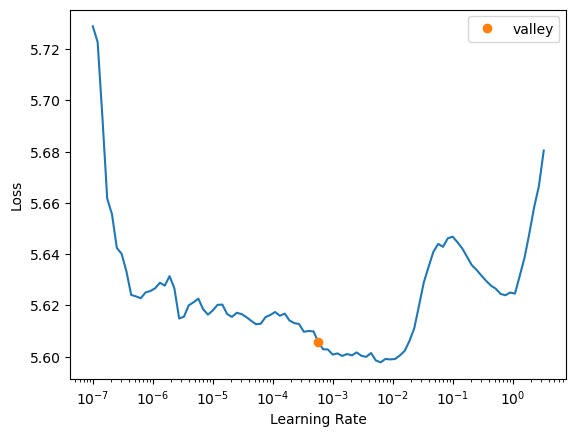

In [51]:
# LEARNING RATE
model = build_ts_model(InceptionTimePlus, dls=dls, depth=9, nf=64, fc_dropout=0, conv_dropout=0)  
learni = Learner(dls, model, metrics=accuracy)
learni = ts_learner(dls, arch=InceptionTimePlus, metrics=accuracy) # == ts_learner(dls, arch=InceptionTimePlus, metrics=accuracy) since InceptionTimePlus is the default arch
learni.lr_find()



epoch,train_loss,valid_loss,accuracy,time
0,5.183735,5.156737,0.000000,05:34


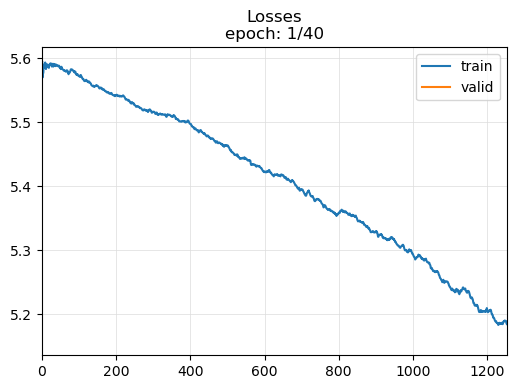

In [ ]:
# early stop https://docs.fast.ai/callback.tracker.html 
EPOCHS=40
learni = ts_learner(dls, metrics=accuracy, cbs=[ShowGraph(), EarlyStoppingCallback(monitor='accuracy', patience=2)])
#learni = ts_learner(dls, metrics=accuracy, cbs=ShowGraph())
learni.fit_one_cycle(EPOCHS, lr_max=10e-4)

#EXPORT MODEL
PATH = f"{ARCHIVE_DIR}/models/modelIncept.pkl"
learni.export(PATH)


In [ ]:



========Full Data - no add Norm, Centered ========
DIM=3 FRAMES=32, FEAT=345
Epoch:38 > Train Loss: 0.9867, Train Acc: 0.7321
Epoch:38 > Val Loss: 1.2608, Val Acc: 0.6988
==================================================

========Full Data - no additional Normalizeation/Centering=====================================
DIM=3 FRAMES=32, FEAT=345
Epoch:39 > Train Loss: 1.4974, Train Acc: 0.6059
Epoch:39 > Val Loss: 1.7298, Val Acc: 0.5839
==================================================

=====Full no reverse, centered =============================================
DIM=3 FRAMES=32, FEAT=345
Epoch:39 > Train Loss: 1.2104, Train Acc: 0.6745
Epoch:39 > Val Loss: 1.4204, Val Acc: 0.6515
==================================================
# Additional Normalize and Nan Step  0.6100

# Consolidated Model

In [ ]:
# SAVE PYTORCH MODELS
class AModel(nn.Module):
    def __init__(self):
        super(AModel, self).__init__()
        
        self.InputFormat = feature_converter
        self.InferModel = model
        self.InferModel.eval()
    
    def forward(self, x):
        x1,x2,x3,x4 = self.InputFormat(x)
        pred = self.InferModel(x1,x2,x3,x4)
        return pred

mod = AModel()
PATH = f"{ARCHIVE_DIR}/models/modelccn{FRAMES_OUT}test.pt"
torch.save(mod, PATH)



In [ ]:

label_map = json.load(open(f"{BASE_DIR}/sign_to_prediction_index_map.json", "r"))
df = pd.read_csv(TRAIN_FILE)
df['label'] = df['sign'].map(label_map)
df.shape

In [ ]:
os.path.join(BASE_DIR, d['path'].item())

In [ ]:
Infmodel = torch.load(PATH)

d = df[2022:2023]

x = load_relevant_data_subset(os.path.join(BASE_DIR, d['path'].item()))
pred = Infmodel(x)

print("truth:", d.label, d.sign, "prediction=", np.argmax(pred.detach().numpy()))
